# 

## Import Statements

In [62]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.io import fits
from astropy.cosmology import LambdaCDM
from matplotlib import pyplot as plt

from xga.imagetools.profile import annular_mask
from xga.imagetools.misc import physical_rad_to_pix
from xga.products import ExpMap

%matplotlib inline

## Define the cosmology

In [49]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Read in the sample

In [7]:
samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))
samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,LoVoCCS_name
0,MCXCJ1558.3+2713,J1558.3+2713,0,239.585833,27.226944,0.0894,10.676087,8.1491,1.3803,RXCJ1558.3+2713,A2142,L,LoVoCCS-0
1,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN,LoVoCCS-1
2,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L,LoVoCCS-2
3,MCXCJ1348.8+2635,J1348.8+2635,3,207.220833,26.595556,0.0622,5.478067,5.5280,1.2236,RXCJ1348.8+2635,A1795,NaN,LoVoCCS-3
4,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr",LoVoCCS-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,MCXCJ0448.2-2028,J0448.2-2028,139,72.050833,-20.469722,0.0720,1.004022,1.9513,0.8620,RXCJ0448.2-2028,A514,losStr,LoVoCCS-139
140,MCXCJ2323.8+1648,J2323.8+1648,140,350.972917,16.808889,0.0416,1.002026,1.9896,0.8760,A2589,A2589,NaN,LoVoCCS-140
141,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X,LoVoCCS-141
142,MCXCJ1459.0-0843,J1459.0-0843,142,224.764583,-8.725000,0.1043,1.001337,1.9047,0.8461,RXCJ1459.0-0843,NaN,NaN,LoVoCCS-142


In [95]:
field_xmm_cov_frac[105]

0.0

## X-ray coverage of the LoVoCCS sample

In [78]:
field_xmm_cov_frac = []
r500_xmm_cov_frac = []
rvir_xmm_cov_frac = []

field_chandra_cov_frac = []
r500_chandra_cov_frac = []
rvir_chandra_cov_frac = []

for row_ind, row in samp.iterrows():
    cov_path = "../../outputs/coverage_maps/fits/{n}_550pix_20.0arcsec.fits".format(n=row["LoVoCCS_name"])
    cur_cheese = ExpMap(cov_path, '', '', '', '', '', Quantity(0.5, 'keV'), Quantity(2.0, 'keV'))
    with fits.open(cov_path) as covero:
        if row_ind == 0:
            print(covero[0].header['MISSION*'])
            
        cov_arr = covero[0].data
        xmm_cov_arr = cov_arr[0, :, :]
        chandra_cov_arr = cov_arr[1, :, :]
        
        field_xmm_cov_frac.append(xmm_cov_arr.sum() / (xmm_cov_arr.shape[0]*xmm_cov_arr.shape[1]))
        field_chandra_cov_frac.append(chandra_cov_arr.sum() / (chandra_cov_arr.shape[0]*chandra_cov_arr.shape[1]))
        
        pix_cen = Quantity([xmm_cov_arr.shape[0]/2, xmm_cov_arr.shape[1]/2], 'pix').round(0).astype(int)
        rad = Quantity(row['R500'], 'Mpc')
        
        pix_rad = physical_rad_to_pix(cur_cheese, rad, pix_cen, row['redshift'], cosmo)
        
        rad_mask = annular_mask(pix_cen, np.array([0]), np.array([pix_rad.value]), xmm_cov_arr.shape)
        msk_xmm_cov = xmm_cov_arr*rad_mask
        r500_xmm_cov_frac.append(msk_xmm_cov.sum() / rad_mask.sum())
        
        msk_chandra_cov = chandra_cov_arr*rad_mask
        r500_chandra_cov_frac.append(msk_chandra_cov.sum() / rad_mask.sum())
        

MISSION1= 'xmm_pointed'                                                         MISSION2= 'chandra '                                                            MISSION3= 'rosat_pointed_pspc'                                                  MISSION4= 'rosat_pointed_hri'                                                   MISSION5= 'nustar_pointed'                                                      END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

### Distribution of coverage of 3.06$^{\circ}$x3.06$^{\circ}$ field centered on MCXC position

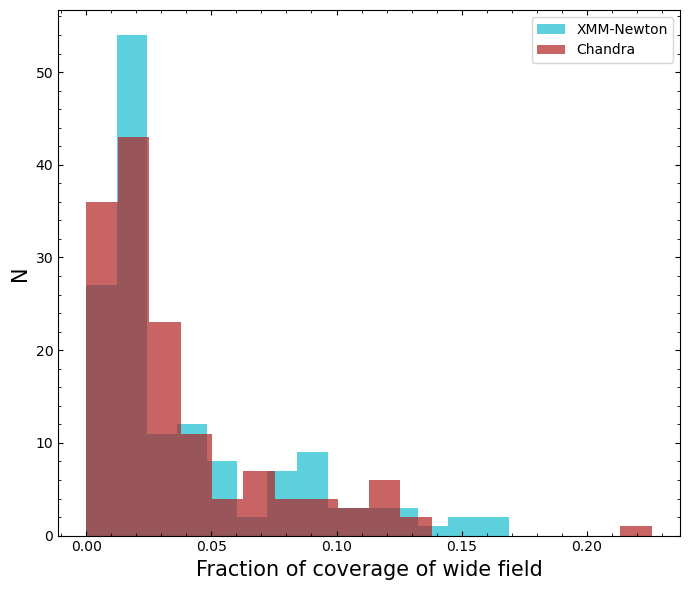

In [76]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(field_xmm_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='XMM-Newton')
plt.hist(field_chandra_cov_frac, bins='auto', color='firebrick', alpha=0.7, label='Chandra')
plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of wide field', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Distribution of coverage of MCXC $R_{500}$ centered on MCXC position

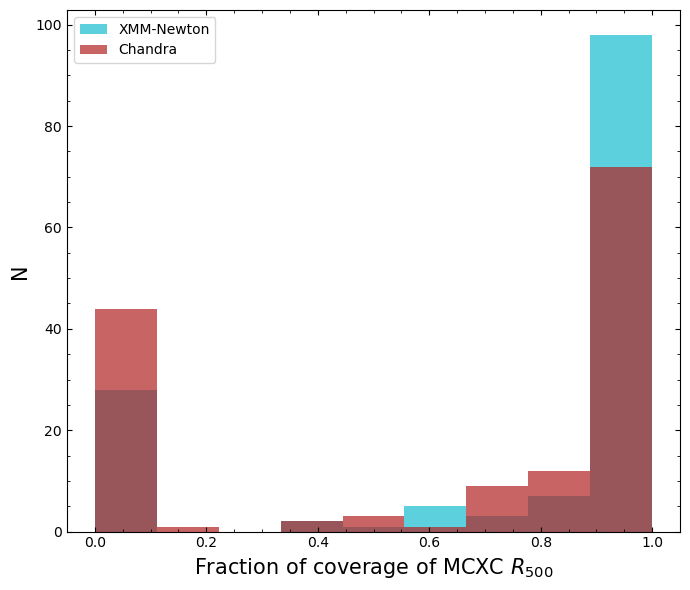

In [79]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(r500_xmm_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='XMM-Newton')
plt.hist(r500_chandra_cov_frac, bins='auto', color='firebrick', alpha=0.7, label='Chandra')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of MCXC $R_{500}$', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Possible categories of target

### No non-RASS X-ray coverage

<span style="color:red">LoVoCCS-99 had an incorrect coordinate, and shouldn't appear here once further data have been downloaded</span>

In [92]:
samp.iloc[np.where((np.array(r500_xmm_cov_frac) == 0) & (np.array(r500_chandra_cov_frac) == 0))]

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,LoVoCCS_name
91,MCXCJ0028.6-2338,J0028.6-2338,91,7.163750,-23.637222,0.1120,1.404549,2.3285,0.9024,RXCJ0028.6-2338,A42,NaN,LoVoCCS-91
99,MCXCJ1516.5-0056,J1516.5-0056,99,229.141667,0.948889,0.1198,1.296543,2.2053,0.8839,RXCJ1516.5-0056,A2051,NaN,LoVoCCS-99
102,MCXCJ1601.3+5354,J1601.3+5354,102,240.347500,53.906111,0.1068,1.238344,2.1643,0.8822,RXCJ1601.3+5354,A2149,NaN,LoVoCCS-102
105,MCXCJ2359.9-3928,J2359.9-3928,105,359.982083,-39.479722,0.1024,1.226090,2.1579,0.8826,RXCJ2359.9-3928,A4068,NaN,LoVoCCS-105
106,MCXCJ1139.4-3327,J1139.4-3327,106,174.863750,-33.453889,0.1076,1.218610,2.1420,0.8789,RXCJ1139.4-3327,NaN,NaN,LoVoCCS-106
108,MCXCJ1006.6+2554,J1006.6+2554,108,151.664583,25.910000,0.1162,1.197113,2.1060,0.8715,RXCJ1006.6+2554,A923,NaN,LoVoCCS-108
110,MCXCJ0726.0+4122,J0726.0+4122,110,111.502083,41.382222,0.1120,1.171477,2.0846,0.8697,RXCJ0726.0+4122,A580,NaN,LoVoCCS-110
112,MCXCJ0107.8-3643,J0107.8-3643,112,16.954583,-36.727222,0.1186,1.156778,2.0589,0.8642,RXCJ0107.8-3643,A2871,NaN,LoVoCCS-112
113,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,LoVoCCS-113
119,MCXCJ1027.9-0647,J1027.9-0647,119,156.998333,-6.796111,0.1176,1.095941,1.9936,0.8553,RXCJ1027.9-0647,A1023,X *,LoVoCCS-119


In [80]:
no_cov = ['LoVoCCS-91', 'LoVoCCS-102', 'LoVoCCS-106', 'LoVoCCS-108', 'LoVoCCS-110', 'LoVoCCS-112', 'LoVoCCS-119', 
          'LoVoCCS-133', 'LoVoCCS-137']
no_cov_samp = samp[samp['LoVoCCS_name'].isin(no_cov)]
some_cov_samp = samp[~samp['LoVoCCS_name'].isin(no_cov)]

#### 

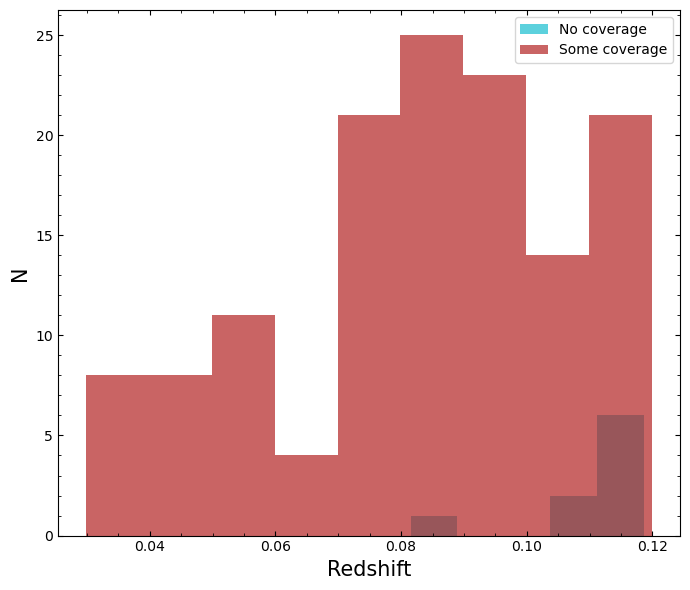

In [81]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(no_cov_samp['redshift'].values, bins='auto', color='tab:cyan', alpha=0.7, label='No coverage')
plt.hist(some_cov_samp['redshift'].values, bins='auto', color='firebrick', alpha=0.7, label='Some coverage')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'Redshift', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

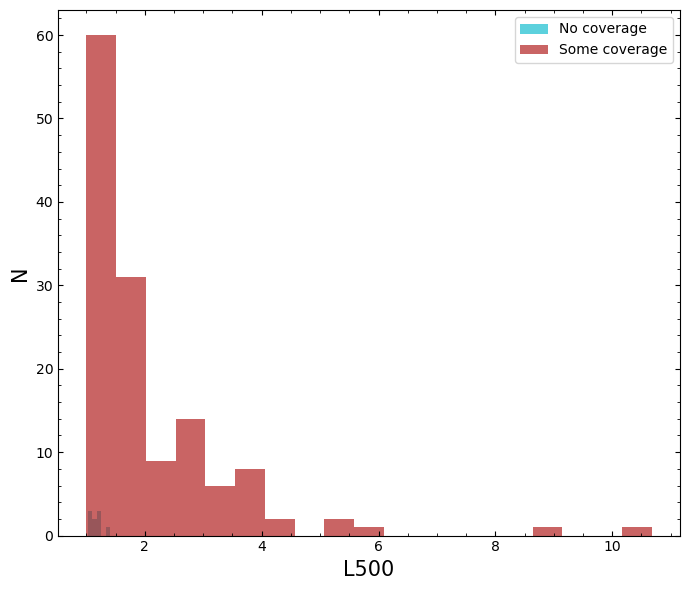

In [82]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(no_cov_samp['L500'].values, bins='auto', color='tab:cyan', alpha=0.7, label='No coverage')
plt.hist(some_cov_samp['L500'].values, bins='auto', color='firebrick', alpha=0.7, label='Some coverage')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'L500', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()